In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from math import pi
import scipy.stats as stats

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from matplotlib import colors as mplcolors

# build report
import reportlab
from reportlab.platypus.flowables import Flowable
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, KeepTogether
from reportlab.lib.pagesizes import A4
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch, cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.colors import HexColor
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors

# the module that has all the methods for handling the data
import resources.featuredata as featuredata
from resources.featuredata import makeAList
# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from PIL import Image as PILImage
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# border and row shading for tables
a_color = "saddlebrown"
table_row = "saddlebrown"

# a place to save figures and a 
# method to choose formats
save_fig_prefix = "resources/output/"

# the arguments for formatting the image
save_figure_kwargs = {
    "fname": None,
    "dpi": 300.0,
    "format": "jpeg",
    "bbox_inches": None,
    "pad_inches": 0,
    "bbox_inches": 'tight',
    "facecolor": 'auto',
    "edgecolor": 'auto',
    "backend": None,
}

## !! Begin Note book variables !!

# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/all_survey_areas_summary.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the all (all) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'all', 'name':"Alle Erhebungsgebiete", 'level':'all'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'river_bassin'

# the doctitle is the unique name for the url of this document
doc_title = "lakes_rivers"


# # identify the lakes of interest for the survey area
# lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]   

# !! End note book variables !!
## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# !key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
fdx.codeGroupSummary()

# !this is the feature data!
fd = fdx.feature_data



# !keyword args to build period data
# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data. For a survey area
# or river bassin these_features = feature_parent and 
# feature_level = parent_level
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()
fdr.adjustForLanguage()
fdr.makeFeatureData()
fdr.locationSampleTotals()
fdr.makeDailyTotalSummary()
fdr.materialSummary()
fdr.mostCommon()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()

# update the admin kwargs with river data to make the river summary
admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]


# pdf download is an option 
# the .pdf output is generated in parallel
# this is the same as if it were on the backend where we would
# have a specific api endpoint for .pdf requests. 
# reportlab is used to produce the document
# the components of the document are captured at run time
# the pdf link gives the name and location of the future doc
pdf_link = f'resources/pdfs/{this_feature["slug"]}_sa.pdf'

# the components are stored in an array and collected as the script runs
pdfcomponents = []

# pdf title and map
pdf_title = Paragraph(this_feature["name"], featuredata.title_style)
map_image =  Image(bassin_map, width=cm*19, height=20*cm, kind="proportional", hAlign= "CENTER")

map_caption = featuredata.defaultMapCaption(language="de")
f1cap = Paragraph(map_caption, featuredata.caption_style),
glue(f'{this_feature["slug"]}_city_map_caption', map_caption, display=False)

def convertPixelToCm(file_name: str = None):
    im = PILImage.open(file_name)
    width, height = im.size
    dpi = im.info.get("dpi", (72, 72))
    width_cm = width / dpi[0] * 2.54
    height_cm = height / dpi[1] * 2.54
    
    return width_cm, height_cm

o_w, o_h = convertPixelToCm(bassin_map)

f1cap = Paragraph(map_caption, style=featuredata.caption_style)

figure_kwargs = {
    "image_file":bassin_map,
    "caption": f1cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 16,
    "caption_height":.75,
    "hAlign": "CENTER",
}

f1 = featuredata.figureAndCaptionTable(**figure_kwargs)


pdfcomponents = featuredata.addToDoc([
    pdf_title,    
    featuredata.small_space,
    f1
    
], pdfcomponents)

'Die Erhebungsorte sind für die Analyse nach Erhebungsgebiet gruppiert. Die Grösse der Markierung gibt einen Hinweis auf die Anzahl Abfallobjekte, die gefunden wurden.'

(allsurveys)=
# Seen und Fliessgewässer

{Download}`Download </resources/pdfs/all_sa.pdf>`

```{figure} resources/maps/all_survey_areas_summary.jpeg
---
name: all_survey_area_city_labels_map
---
` `
```
{numref}`Abbildung %s: <all_survey_area_city_labels_map>` {glue:text}`all_city_map_caption`

In [2]:
# the admin summary can be converted into a standard text
an_admin_summary = featuredata.makeAdminSummaryStateMent(start_date, end_date, this_feature["name"], admin_summary=admin_summary)
                      
# collect component features and land marks
# this collects the components of the feature of interest (city, lake, river)
# a comma separated string of all the componenets and a heading for each component
# type is produced
feature_components = featuredata.collectComponentLandMarks(admin_details, language="de")

# markdown output
components_markdown = "".join([f'*{x[0]}*\n\n>{x[1]}\n\n' for x in feature_components])

new_components = [
    featuredata.small_space,
    Paragraph("Erhebungsorte", featuredata.section_title), 
    featuredata.smallest_space,
    Paragraph(an_admin_summary , featuredata.p_style),
]

# add the admin summary to the pdf
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

# put that all together:
lake_string = F"""
{an_admin_summary}

{"".join(components_markdown)}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 386 Datenerhebungen insgesamt 54 744 Objekte entfernt und identifiziert.  Die Ergebnisse des Alle Erhebungsgebiete umfassen 143 Orte, 77 Gemeinden und eine Gesamtbevölkerung von etwa 1 735 991 Einwohnenden.

*Seen*

>Zürichsee, Lac Léman, Lago Maggiore, Thunersee, Bielersee, Lago di Lugano, Neuenburgersee, Walensee, Brienzersee, Vierwaldstättersee, Zugersee

*Fliessgewässer*

>Aare, Nidau-Büren-Kanal, Ticino, Cassarate, Jona, Dorfbach, La Thièle, Rhône, Limmat, Linthkanal, Escherkanal, Reuss, Maggia, Schüss, Emme, Seez, Sihl

*Gemeinden*

>Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich




## Landnutzungsprofil

Die Erhebungsgebiete sind nach Flusseinzugsgebieten gruppiert. In diesem Bericht werden mehrere Einzugsgebiete zusammengefasst, um regionale Trends zu analysieren: 

* Aare: Emme, Aare 
* Linth: Reuss, Linth, Limmat 
* Rhône: Rhône 
* Tessin/Ceresio: Tessin, Luganersee, Lago Maggiore

Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von den folgenden vier Kategorien zugewiesen:.       

* Fläche, die von Gebäuden eingenommen wird in \%
* Fläche, die dem Wald vorbehalten ist in \%
* Fläche, die für Aktivitäten im Freien genutzt wird in \%
* Fläche, die von der Landwirtschaft genutzt wird in \%

Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer innerhalb eines Radius von 1500 m angegeben.

Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von 1500 m um den Erhebungsort herum in das Gewässer münden.

Das Verhältnis der gefundenen Abfallobjekte unterscheidet sich je nach Landnutzungsprofil. Das Verhältnis gibt daher einen Hinweis auf die ökologischen und wirtschaftlichen Bedingungen um den Erhebungsort.

Weitere Informationen gibt es im Kapitel [_Landnutzungsprofil_](luseprofile)

__Verteilung der Landnutzungsmerkmale__

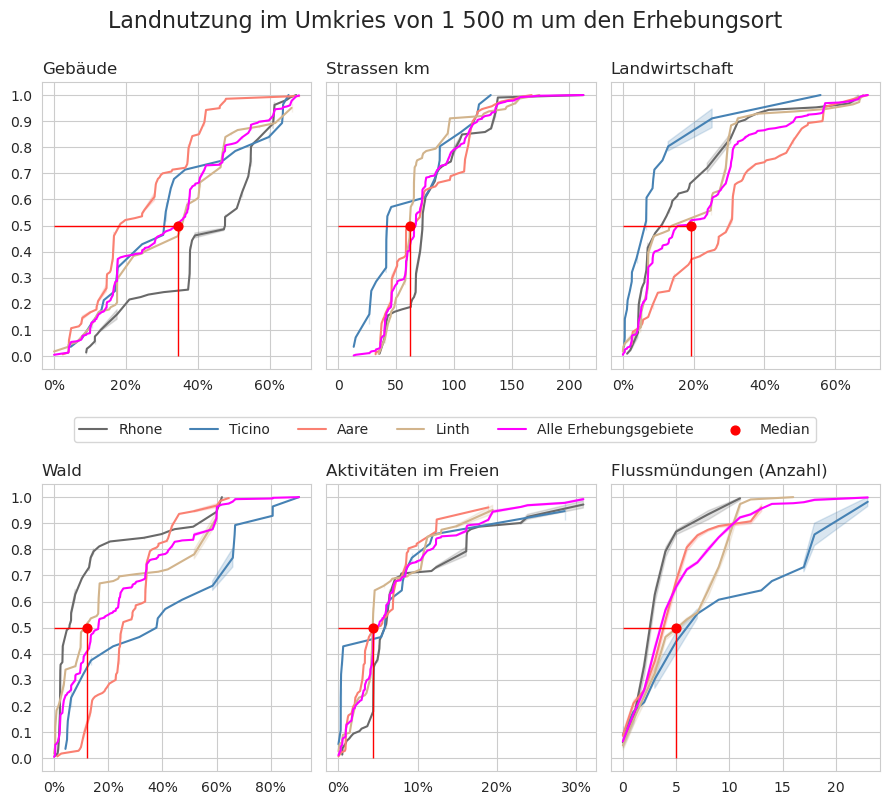

'Die Erhebungen in den Gebieten Rhône und Linth wiesen mit 47 % bzw. 40 % im Median den grössten Anteil an bebauter Fläche (Gebäude) und mit 5 % bzw. 8 % den geringsten Anteil an Wald auf. Im Erhebungsgebiet Aare war der Medianwert der bebauten Fläche (Gebäude) mit 16 % am niedrigsten und der Anteil der landwirtschaftlich genutzten Fläche mit 30 % am höchsten. Bei den Flächen, die den Aktivitäten im Freien zugeordnet werden, handelt es sich um Sportplätze, öffentliche Strände und andere öffentliche Versammlungsorte.'

In [3]:
# the land use data per location (for all locations) for a radius of 1 500 m is
# available woth the survey results. Using the period data gets the land use 
# rates for all locations (not just the feature of interest)
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_level   
}

# the landuse profile of the project
project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()

# change the data in the land_use_kargs to get different rates
# update the kwargs for the feature data
land_use_kwargs.update({"data":fdx.feature_data})

# build the landuse profile of the feature
feature_profile = featuredata.LandUseProfile(**land_use_kwargs)

# this is the component features of the report
feature_landuse = feature_profile.featureOfInterest()

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")

for i, n in enumerate(featuredata.default_land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]
    
    # the value of land use feature n
    # for each element of the feature
    for element in feature_landuse:
        # the land use data for a feature
        data = element[n].values
        # the name of the element
        element_name = element[feature_profile.feature_level].unique()
        # proper name for chart
        label = featuredata.river_basin_de[element_name[0]]
        # cumulative distribution        
        xs, ys = featuredata.empiricalCDF(data)
        # the plot of landuse n for this element
        sns.lineplot(x=xs, y=ys, ax=ax, label=label, color=featuredata.bassin_pallette[element_name[0]])
    
    # the value of the land use feature n for the project
    testx, testy = featuredata.empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label=top, color="magenta")
    
    # get the median landuse for the feature
    the_median = np.median(data)
    
    # plot the median and drop horizontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=40, linewidth=1, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=1)
    
    if i <= 3:
        if c == 0:            
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_title(featuredata.luse_de[n], loc='left')
    
plt.tight_layout()
plt.subplots_adjust(top=.91, hspace=.5)
plt.suptitle("Landnutzung im Umkries von 1 500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.5), loc="upper center", ncol=6) 
figure_caption = [
    f"Die Erhebungen in den Gebieten Rhône und Linth wiesen mit {'47 %'} bzw. {'40 %'} im ",
    f"Median den grössten Anteil an bebauter Fläche (Gebäude) und mit {'5 %'} bzw. {'8 %'} ",
    "den geringsten Anteil an Wald auf. Im Erhebungsgebiet Aare war der Medianwert der ",
    f"bebauten Fläche (Gebäude) mit {'16 %'} am niedrigsten und der Anteil der landwirtschaftlich ",
    f"genutzten Fläche mit {'30 %'} am höchsten. Bei den Flächen, die den Aktivitäten im Freien ",
    "zugeordnet werden, handelt es sich um Sportplätze, öffentliche Strände und andere öffentliche Versammlungsorte."
]

land_use_figure_caption = ''.join(figure_caption)

figure_name = f'{this_feature["slug"]}_survey_area_landuse',
land_use_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":land_use_file_name})

plt.tight_layout()
plt.subplots_adjust(top=.91, hspace=.4)
plt.savefig(**save_figure_kwargs)

# capture the output
glue( f'{this_feature["slug"]}_survey_area_landuse', fig, display=False)
glue(f'{this_feature["slug"]}_land_use_caption', land_use_figure_caption, display=False)
plt.close() 

```{glue:figure} all_survey_area_landuse
---
name: 'all_survey_area_landuse'
---
` `
```
{numref}`Abbildung %s: <all_survey_area_landuse>` {glue:text}`all_land_use_caption`

### Gesamtergebnisse nach Erhebungsgebiet

In [4]:
# the dimensional data
dims_table = admin_details.dimensionalSummary()

# a method to update the place names from slug to proper name
name_map = featuredata.river_basin_de

# the order in which they are charted
name_order = list(name_map.keys())

# sort by quantity
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)

# apply language settings
dims_table.rename(columns=featuredata.dims_table_columns_de, inplace=True)

# convert to kilos
dims_table["Plastik (Kg)"] = dims_table["Plastik (Kg)"]/1000

# save a copy of the dims_table for working
# formatting to pdf will turn the numerics to strings
# which eliminates any further calclations
dims_df =  dims_table.copy()

# these columns need formatting for locale
thousands_separated = ["Fläche (m2)", "Länge (m)", "Erhebungen", "Objekte (St.)"]
replace_decimal = ["Plastik (Kg)", "Gesamtgewicht (Kg)"]

# format the dimensional summary for .pdf and add to components
dims_table[thousands_separated] = dims_table[thousands_separated].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
dims_table[replace_decimal] = dims_table[replace_decimal].applymap(lambda x: featuredata.replaceDecimal(str(round(x,2))))

# subsection title
subsection_title = Paragraph("Gesamtergebnisse nach Erhebungsgebiet", featuredata.subsection_title)

# a caption for the figure
caption_kwargs = {
        "name": "caption_style",
        "fontSize": 9,
        "fontName": "Times-Italic",
        "leftIndent":6
       
    }
new_caption_style = ParagraphStyle(**caption_kwargs)

dims_table_caption = [
    "Summen der Ergebnisse für alle Erhebungsgebiete. Im Gebiet Aare ist die ",
    "Anzahl Erhebungen am grössten. Gleichzeitig ist dort die Anzahl gesammelter ",
    "Objekte pro Fläche am geringsten."
]

# pdf table out
dims_table_caption = ''.join(dims_table_caption)
col_widths = [3.5*cm, 3*cm, *[2.2*cm]*(len(dims_table.columns)-1)]

dims_pdf_table = featuredata.aSingleStyledTable(dims_table, colWidths=col_widths, style=featuredata.default_table_style)
dims_pdf_table_caption = Paragraph(dims_table_caption, new_caption_style)

dims_pdf_table_and_caption = featuredata.tableAndCaption(dims_pdf_table, dims_pdf_table_caption,col_widths)

new_components = [
    featuredata.large_space,
    subsection_title,
    featuredata.small_space,
    dims_pdf_table_and_caption       
]
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)
# end pdf table

# this formats the table through the data frame
dims_df["Plastik (Kg)"] = dims_df["Plastik (Kg)"].round(2)
dims_df["Gesamtgewicht (Kg)"] = dims_df["Gesamtgewicht (Kg)"].round(2)
dims_df[thousands_separated] = dims_df[thousands_separated].astype("int")

# set the index name to None so it doesn't show in the columns
dims_df.index.name = None
dims_df.columns.name = None

# this applies formatting to the specifc column based on
# the language.
dims_table_formatter = {
    "Plastik (Kg)": lambda x: featuredata.replaceDecimal(x, "de"),
    "Gesamtgewicht (Kg)": lambda x: featuredata.replaceDecimal(x, "de"),
    "Fläche (m2)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Länge (m)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Erhebungen": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de")
}

# use the caption from the .pdf for the online figure
glue(f'{this_feature["slug"]}_dims_table_caption',dims_table_caption, display=False)

# apply formatting and styles to dataframe
q = dims_df.style.format(formatter=dims_table_formatter).set_table_styles(table_css_styles)

# capture the figure before display and give it a reference number and caption
figure_name=f'{this_feature["slug"]}_dims_table'
glue(figure_name, q, display=False)

'Summen der Ergebnisse für alle Erhebungsgebiete. Im Gebiet Aare ist die Anzahl Erhebungen am grössten. Gleichzeitig ist dort die Anzahl gesammelter Objekte pro Fläche am geringsten.'

,Gesamtgewicht (Kg),Plastik (Kg),Fläche (m2),Länge (m),Erhebungen,Objekte (St.)
Alle Erhebungsgebiete,"305,51","94,21",96 616,19 722,386,54 744
rhone,"151,31","45,97",25 986,4 911,106,28 454
aare,"71,98","31,45",37 017,7 971,140,13 847
linth,"35,96","12,77",25 637,5 323,112,9 412
ticino,"46,26","4,03",7 974,1 517,28,3 031


```{glue:figure} all_dims_table
:name: "all_dims_table"


` `

```

{numref}`Abbildung {number}: <all_dims_table>` {glue:text}`all_dims_table_caption`

In [5]:
section_title =  "Landnutzungsprofil der Erhebungsorte"

section_summary = [
    "Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius ",
    "von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von ",
    "den folgenden vier Kategorien zugewiesen:"
]

section_definition = [
    "Fläche, die von Gebäuden eingenommen wird in %",
    "Fläche, die dem Wald vorbehalten ist in %",
    "Fläche, die für Aktivitäten im Freien genutzt wird in %",
    "Fläche, die von der Landwirtschaft genutzt wird in %"
]

p_one = [
    "Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer ",
    "innerhalb eines Radius von 1500 m angegeben."
]

p_two = [
    "Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von ",
    "1500 m um den Erhebungsort herum in das Gewässer münden."
]

p_three = [
    "Das Verhältnis der gefundenen Abfallobjekte unterscheidet sich ",
    "je nach Landnutzungsprofil. Das Verhältnis gibt daher einen Hinweis ",
    "auf die ökologischen und wirtschaftlichen Bedingungen um den Erhebungsort.",
]

# make paragraphs
land_use_subtitle = Paragraph(section_title, featuredata.section_title)
land_use_summary = Paragraph(''.join(section_summary), featuredata.p_style)

definition_list = makeAList(section_definition)

para_one = Paragraph("".join(p_one), featuredata.p_style)
para_two = Paragraph("".join(p_two), featuredata.p_style)
para_three = Paragraph("".join(p_three), featuredata.p_style)

new_components = [
    KeepTogether([        
        land_use_subtitle,
        featuredata.small_space,
        land_use_summary,
        featuredata.smallest_space,
        definition_list,
        featuredata.smallest_space,
        para_one,
        featuredata.smallest_space,
        para_two,
        featuredata.smallest_space,
        para_three
    ])
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

In [6]:
land_use_caption = Paragraph(land_use_figure_caption, new_caption_style)

figure_kwargs = {
    "image_file": land_use_file_name,
    "caption": land_use_caption,
    "desired_width": 14.5,
    "original_height": 20.32,
    "original_width": 22.86,
    "caption_height": 3.0,
    "style": featuredata.figure_table_style
}

figure_and_caption = featuredata.figureAndCaptionTable(**figure_kwargs)

new_components = [
    featuredata.small_space,
    figure_and_caption  
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

## Erhebungsergebnisse für alle Objekte

Verteilung der Erhebungsergebnisse. Die Werte werden als Anzahl der identifizierten Abfallobjekte pro 100 Meter (p/100 m) dargestellt. 

'Links: Alle Erhebungen zwischen März 2020 bis Mai 2021, gruppiert nach Erhebungsgebiet und aggregiert zum monatlichen Median. Werte über 1778 p/100 m sind nicht dargestellt. Rechts: Die empirische Verteilungsfunktion der Gesamtwerte der Erhebungen.'

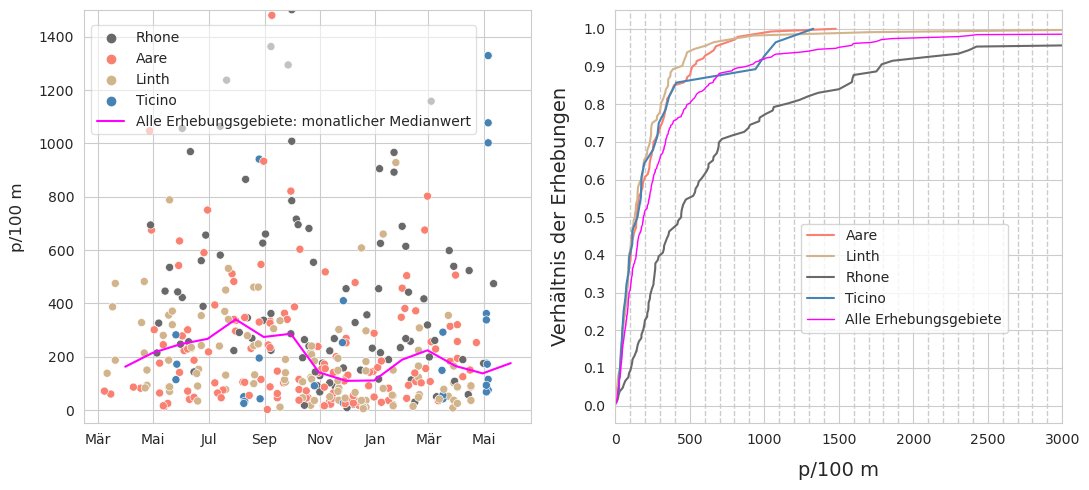

In [7]:
# the sample totals of the parent feautre
dx = period_data.parentSampleTotals(parent=False)

# get the monthly or quarterly results for the feature
rsmp = fdx.sample_totals.set_index("date")
resample_plot, rate = featuredata.quarterlyOrMonthlyValues(rsmp, this_feature["name"], vals=unit_label)

fig, axs = plt.subplots(1,2, figsize=(11,5))

ax = axs[0]

# axis notations
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# adjust the pallette
bassin_pallette = {k:v for k, v in featuredata.bassin_pallette.items() if k in fdx.sample_totals.river_bassin.unique()}
name_order = bassin_pallette.keys()

# feature surveys
sns.scatterplot(data=fdx.sample_totals, x="date", y=unit_label, hue='river_bassin', hue_order=name_order, palette=bassin_pallette, s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

# label the yaxis
ax.set_ylabel(unit_label, **{'labelpad':10, 'fontsize':12})

# label the xaxis
ax.set_xlabel("")

# format ticks and locations
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.set_ylim(-50, 1500)

# the legend labels need to be changed to proper names
h, l = ax.get_legend_handles_labels()
new_labels = [*[name_map[x] for x in l[:-1]], l[-1]]

# apply new labels and legend
ax.legend(h, new_labels, bbox_to_anchor=(0, .98), loc="upper left", ncol=1, framealpha=.6)

# the cumlative distributions:
axtwo = axs[1]

# for each survey area:
for basin in name_map.keys():
    # filter the data for the element
    mask = fdx.sample_totals.river_bassin == basin
    ecdf_data = fdx.sample_totals[mask]
    # make the ECDF and make the plot
    feature_ecd = featuredata.ecdfOfAColumn(ecdf_data, unit_label)    
    sns.lineplot(x=feature_ecd["x"], y=feature_ecd["y"], color=featuredata.bassin_pallette[basin], ax=axtwo, label=name_map[basin])

# the ecdf of the parent element
other_features = featuredata.ecdfOfAColumn(dx, unit_label)
sns.lineplot(x=other_features["x"], y=other_features["y"], color="magenta", label=top, linewidth=1, ax=axtwo)

# the axist labels
axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

# set the limit of the xaxis, other wise it can go on forever
axtwo.set_xlim(0, 3000)

# set and locate the ticks on the x and y axis
axtwo.xaxis.set_major_locator(MultipleLocator(500))
axtwo.xaxis.set_minor_locator(MultipleLocator(100))
axtwo.yaxis.set_major_locator(MultipleLocator(.1))

# format the minor gridlines
axtwo.grid(which="minor", visible=True, axis="x", linestyle="--", linewidth=1)
axtwo.legend(bbox_to_anchor=(.4,.5), loc="upper left")

plt.tight_layout()


figure_name = f"{this_feature['slug']}_sample_totals"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
sample_total_notes = [    
    "Links: Alle Erhebungen zwischen März 2020 bis Mai 2021, gruppiert nach ",
    f"Erhebungsgebiet und aggregiert zum monatlichen Median. Werte über {'1778 '}{unit_label} ",
    "sind nicht dargestellt. Rechts: Die empirische Verteilungsfunktion der Gesamtwerte ",
    "der Erhebungen." 
]

sample_total_notes = ''.join(sample_total_notes)

glue(f'{this_feature["slug"]}_sample_total_notes', sample_total_notes, display=False)
glue(f'{this_feature["slug"]}_sample_totals', fig, display=False)

plt.close()

```{glue:figure} all_sample_totals
:name: "all_sample_totals"


` `

```

{numref}`Abbildung {number}: <all_sample_totals>` {glue:text}`all_sample_total_notes`

__Abfall nach Materialarten im Überblick__

'Links: Zusammenfassung der Resultate für alle Erhebungsgebiete. Rechts: Materialarten in Stückzahlen und als Prozentsatz an der Gesamtmenge (Stückzahl) für alle Erhebungsgebiete.'

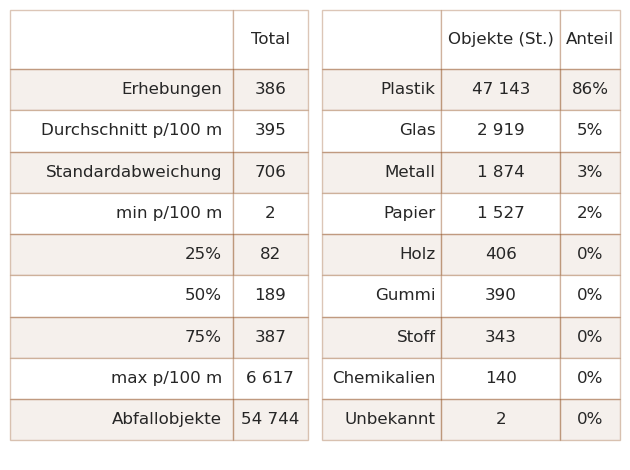

In [8]:
# the summary of the sample totals
csx = fdx.sample_summary.copy()

# format for the current language
combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]

# the materials table
fd_mat_totals = fdx.material_summary.copy()
fd_mat_totals = featuredata.fmtPctOfTotal(fd_mat_totals, around=0)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Objekte (St.)", "% of total":"Anteil"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], featuredata.thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2)

# names for the table columns
a_col = [this_feature["name"], "Total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(12)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .4,.2],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
# figure caption
summary_of_survey_totals = [
    "Links: Zusammenfassung der Resultate für alle Erhebungsgebiete. ",
    "Rechts: Materialarten in Stückzahlen und als Prozentsatz an der ",
    "Gesamtmenge (Stückzahl) für alle Erhebungsgebiete."
]
 
summary_of_survey_totals = ''.join(summary_of_survey_totals)
glue(f'{this_feature["slug"]}_sample_summaries_caption', summary_of_survey_totals, display=False)

figure_name = f'{this_feature["slug"]}_sample_summaries'
sample_summaries_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_summaries_file_name})

plt.savefig(**save_figure_kwargs)
glue(f'{this_feature["slug"]}_survey_area_sample_material_tables', fig, display=False)
plt.close()

```{glue:figure} all_survey_area_sample_material_tables
:name: "all_survey_area_sample_material_tables"

` `
```

{numref}`Abbildung {number}: <all_survey_area_sample_material_tables>` {glue:text}`all_sample_summaries_caption`

## Die am häufigsten gefundenen Gegenstände

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate).

In [9]:
# add summary tables to pdf
subsection_summary = [
    "Verteilung der Erhebungsergebnisse. Die Werte werden als ",
    "Anzahl der identifizierten Abfallobjekte pro 100 Meter (p/100 m) dargestellt."
]

subsection_summary = ''.join(subsection_summary)

sample_summary_subsection = Paragraph("Erhebungsergebnisse für alle Objekte", featuredata.subsection_title)
sample_summary_paragraph = Paragraph(subsection_summary, featuredata.p_style)

# caption_style = ParagraphStyle(**{"name": "caption_style", "fontSize": 9, "fontName": "Times-Italic"})
s_totals_caption = Paragraph(sample_total_notes, new_caption_style)

figure_kwargs = {
    "image_file": sample_totals_file_name,
    "caption": s_totals_caption,
    "desired_width": 14,
    "original_height": 12.7,
    "original_width": 27.94,
    "caption_height":1.5,
    "style": featuredata.figure_table_style
}

s_totals_figure_and_caption = featuredata.figureAndCaptionTable(**figure_kwargs)

samp_material_caption = Paragraph(summary_of_survey_totals, new_caption_style)
figure_kwargs = {
    "image_file": sample_summaries_file_name,
    "caption": samp_material_caption,
    "desired_width": 12,
    "original_height": 11,
    "original_width": 15.24,
    "caption_height": 1.5,
    "style": featuredata.figure_table_style
}

s_totals_material_and_caption = featuredata.figureAndCaptionTable(**figure_kwargs)

samp_mat_subsection = Paragraph("Abfall nach Materialarten im Überblick", featuredata.subsection_title)

new_components = [KeepTogether([
    featuredata.small_space,
    sample_summary_subsection,
    featuredata.small_space,
    sample_summary_paragraph,
    featuredata.small_space,
    s_totals_figure_and_caption,
    featuredata.small_space,
    samp_mat_subsection,
    featuredata.small_space,
    s_totals_material_and_caption,
    PageBreak()
    
])]
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

In [10]:
# add new section to pdf
mc_section_title = Paragraph("Die am häufigsten gefundenen Gegenstände", featuredata.section_title)
para_g =  [
    "Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten ",
    f"vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller ",
    "Datenerhebungen identifiziert wurden (Häufigkeitsrate)"
]

para_g = ''.join(para_g)
mc_section_para = Paragraph(para_g, featuredata.p_style)

# the most common objects results
most_common_display = fdx.most_common

# language appropriate columns
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})

# data for display
most_common_display.rename(columns=cols_to_use, inplace=True)
most_common_display = most_common_display[cols_to_use.values()].copy()
most_common_display = most_common_display.set_index("Objekte", drop=True)

# .pdf output
data = most_common_display.copy()
data["Anteil"] = data["Anteil"].map(lambda x: f"{int(x)}%")
data['Objekte (St.)'] = data['Objekte (St.)'].map(lambda x:featuredata.thousandsSeparator(x, language))
data['Häufigkeitsrate'] = data['Häufigkeitsrate'].map(lambda x: f"{x}%")
data[unit_label] = data[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

dxi = data.copy()
# make caption
# get percent of total to make the caption string
mc_caption_string = [
    "Die häufigsten Objekte für alle Erhebungsgebiete. Die Häufigkeitsrate gibt an, wie oft ein Objekt "
    "in den Erhebungen im Verhältnis zu allen Erhebungen identifiziert wurde: Zigarettenfilter ",
    f"beispielsweise wurden in {'87'} {'%'} der Erhebungen gefunden. Zusammengenommen machen die häufigsten ",
    f"Objekte {'68'} {'%'} aller gefundenen Objekte aus."
]
   
mc_caption_string = "".join(mc_caption_string)
col_widths = [4.5*cm, 2.2*cm, 2*cm, 2.8*cm, 2*cm]

mc_table = featuredata.aSingleStyledTable(data, colWidths=col_widths)
mc_table_caption = Paragraph(mc_caption_string, new_caption_style)

t_and_c = featuredata.tableAndCaption(mc_table, mc_table_caption,col_widths)

new_components = [
    KeepTogether([
        mc_section_title,
        featuredata.small_space,
        mc_section_para
    ]),
    featuredata.small_space,
    t_and_c
       
]
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

most_common_display.index.name = None
most_common_display.columns.name = None

# set pandas display
aformatter = {
    "Anteil":lambda x: f"{int(x)}%",
    f"{unit_label}": lambda x: featuredata.replaceDecimal(x, "de"),
    "Häufigkeitsrate": lambda x: f"{int(x)}%",   
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de")
}

mcd = most_common_display.style.format(aformatter).set_table_styles(table_css_styles)
glue(f'{this_feature["slug"]}_most_common_caption', mc_caption_string, display=False)
glue(f'{this_feature["slug"]}_most_common_tables', mcd, display=False)

'Die häufigsten Objekte für alle Erhebungsgebiete. Die Häufigkeitsrate gibt an, wie oft ein Objekt in den Erhebungen im Verhältnis zu allen Erhebungen identifiziert wurde: Zigarettenfilter beispielsweise wurden in 87 % der Erhebungen gefunden. Zusammengenommen machen die häufigsten Objekte 68 % aller gefundenen Objekte aus.'

,Objekte (St.),Anteil,Häufigkeitsrate,p/100 m
Zigarettenfilter,8 485,15%,87%,"20,0"
Fragmentierte Kunststoffe,7 400,13%,86%,"18,0"
Expandiertes Polystyrol,5 563,10%,68%,"5,0"
Snack-Verpackungen,3 325,6%,85%,"9,0"
Industriefolie (Kunststoff),2 534,4%,69%,"5,0"
"Getränkeflaschen aus Glas, Glasfragmente",2 136,3%,65%,"3,0"
Industriepellets (Nurdles),1 968,3%,30%,"0,0"
Schaumstoffverpackungen/Isolierung,1 702,3%,53%,"1,0"
Wattestäbchen/Tupfer,1 406,2%,50%,"1,0"
Styropor < 5mm,1 209,2%,25%,"0,0"


```{glue:figure} all_most_common_tables
:name: "all_most_common_tables"

` `
```
{numref}`Abbildung {number}: <all_most_common_tables>`{glue:text}`all_most_common_caption`

__Häufigste Objekte im Median p/100 m nach Erhebungsgebiet__

In [11]:
mc_heat_map_caption = [
    f'Der Median {unit_label} der häufigsten Objekte für alle Erhebungsgebiete. Die Werte ',
    'für die jeweiligen Erhebungsgebiete unterscheiden sich deutlich.'
]
mc_heat_map_caption = ''.join(mc_heat_map_caption)

# calling componentsMostCommon gets the results for the most common codes
# at the component level
components = fdx.componentMostCommonPcsM()

# map to proper names for features
feature_names = featuredata.river_basin_de

# pivot that and quash the hierarchal column index that is created when the table is pivoted
mc_comp = components[["item", unit_label, this_level]].pivot(columns=this_level, index="item")
mc_comp.columns = mc_comp.columns.get_level_values(1)

# insert the proper columns names for display
proper_column_names = {x : feature_names[x] for x in mc_comp.columns}
mc_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated total of the feature is taken from the most common objects table
mc_feature = fdx.most_common[unit_label]
mc_feature = featuredata.changeSeriesIndexLabels(mc_feature, {x:fdx.dMap.loc[x] for x in mc_feature.index})

# the aggregated totals of all the period data
mc_period = period_data.parentMostCommon(parent=False)
mc_period = featuredata.changeSeriesIndexLabels(mc_period, {x:fdx.dMap.loc[x] for x in mc_period.index})

# add the feature, bassin_label and period results to the components table
mc_comp["Alle Erhebungsgebiete"]= mc_feature
# mc_comp[top] = mc_period

# pdf out put
def splitTableWidth(data, caption_prefix: str = None, caption: str = None, gradient=False,  
                    this_feature: str = None, vertical_header: bool = False, colWidths=[4*cm, *[None]*len(data.columns)]):
        
    if len(data.columns) > 13:
        tables = featuredata.aStyledTableExtended(data, gradient=gradient, caption_prefix=caption_prefix, vertical_header=vertical_header, colWidths=colWidths)
    else:
        
        mc_table = featuredata.aSingleStyledTable(data, colWidths=col_widths, vertical_header=True, gradient=gradient)
        mc_table_caption = Paragraph(caption, new_caption_style)

        table = featuredata.tableAndCaption(mc_table, mc_table_caption,col_widths)
           
    return table

caption_prefix =  f'Median {unit_label} der häufigsten Objekte am '
col_widths=[4.5*cm, *[1.2*cm]*(len(mc_comp.columns)-1)]
mc_heatmap_title = Paragraph(f"Häufigste Objekte im Median {unit_label} nach Erhebungsgebiet", featuredata.bold_block)
tables = splitTableWidth(mc_comp, gradient=True, caption_prefix=caption_prefix, caption=mc_heat_map_caption,
                    this_feature=this_feature["name"], vertical_header=True, colWidths=col_widths)

# identify the tables variable as either a list or a Flowable:
if isinstance(tables, list):
    grouped_pdf_components = [*tables]
else:
    grouped_pdf_components = [tables]
    

new_components = [
    featuredata.small_space,
    mc_heatmap_title,
    featuredata.small_space,
    *grouped_pdf_components
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

# notebook display style
aformatter = {x: featuredata.replaceDecimal for x in mc_comp.columns}
mcd = mc_comp.style.format(aformatter).set_table_styles(table_css_styles)
mcd = mcd.background_gradient(axis=None, vmin=mc_comp.min().min(), vmax=mc_comp.max().max(), cmap="YlOrBr")

# remove the index name and column name labels
mcd.index.name = None
mcd.columns.name = None

# rotate the text on the header row
# the .applymap_index method in the
# df.styler module is used for this
mcd = mcd.applymap_index(featuredata.rotateText, axis=1)

# display markdown html
glue(f'{this_feature["slug"]}_mc_heat_map_caption', mc_heat_map_caption, display=False)

glue(f'{this_feature["slug"]}_most_common_heat_map', mcd, display=False)

'Der Median p/100 m der häufigsten Objekte für alle Erhebungsgebiete. Die Werte für die jeweiligen Erhebungsgebiete unterscheiden sich deutlich.'

,Aare,Linth,Rhone,Ticino,Alle Erhebungsgebiete
"Getränkeflaschen aus Glas, Glasfragmente","3,0","4,0","2,0","8,0","3,0"
Expandiertes Polystyrol,"4,0","3,0","17,5","6,0","5,0"
Fragmentierte Kunststoffe,"18,5","10,5","48,0","9,5","18,0"
Industriefolie (Kunststoff),"5,0","2,0","9,0","3,5","5,0"
Industriepellets (Nurdles),"0,0","0,0","0,0","0,0","0,0"
"Kronkorken, Lasche von Dose/Ausfreisslachen","0,0","1,0","3,0","1,0","1,0"
Kunststoff-Bauabfälle,"0,0","0,0","5,5","2,5","1,0"
Schaumstoffverpackungen/Isolierung,"0,0","0,0","7,0","3,0","1,0"
Snack-Verpackungen,"8,0","6,0","19,0","4,0","9,0"
Styropor < 5mm,"0,0","0,0","0,0","0,0","0,0"


```{glue:figure} all_most_common_heat_map
:name: "all_most_common_heat_map"

` `

```

{numref}`Abbildung {number}: <all_most_common_heat_map>` {glue:text}`all_mc_heat_map_caption`

__Häufigste Objekte im Monatsdurchschnitt__

In [12]:
# collect the survey results of the most common objects
# and aggregate code with groupname for each sample
# use the index from the most common codes to select from the feature data
# the aggregation method and the columns to keep
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
groups = ["loc_date","date","code", "groupname"]
# make the range for one calendar year
start_date = "2020-04-01"
end_date = "2021-03-31"
# aggregate
m_common_m = fd[(fd.code.isin(fdx.most_common.index))].groupby(groups, as_index=False).agg(agg_pcs_quantity)
# set the index to the date column and sort values within the date rage
m_common_m.set_index("date", inplace=True)
m_common_m = m_common_m.sort_index().loc[start_date:end_date]

# set the order of the chart, group the codes by groupname columns and collect the respective object codes
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# use the order array and resample each code for the monthly value
# store in a dict
mgr = {}
for a_code in an_order:
    # resample by month
    a_cell = m_common_m[(m_common_m.code==a_code)][unit_label].resample("M").mean().fillna(0)
    a_cell = round(a_cell, 1)
    this_group = {a_code:a_cell}
    mgr.update(this_group)

# make df form dict and collect the abbreviated month name set that to index
by_month = pd.DataFrame.from_dict(mgr)
by_month["month"] = by_month.index.map(lambda x: get_month_names('abbreviated', locale=date_lang)[x.month])
by_month.set_index('month', drop=True, inplace=True)

# transpose to get months on the columns and set index to the object description
by_month = by_month.T
by_month["Objekt"] = by_month.index.map(lambda x: fdx.dMap.loc[x])
by_month.set_index("Objekt", drop=True, inplace=True)

mc_monthly_title = Paragraph("Häufigste Objekte im Monatsdurchschnitt", featuredata.subsection_title)
monthly_data_caption = f'Monatliches Durchschnittsergebnis der Erhebungen als {unit_label} der häufigsten Objekte für alle Erhebungsgebiete.'
figure_caption = Paragraph(monthly_data_caption, featuredata.caption_style)

# apply formatting to df for pdf figure/*
col_widths = [4.5*cm, *[1*cm]*(len(mc_comp.columns)-1)]

# make pdf table
col_widths = [4.5*cm, *[1.2*cm]*(len(mc_comp.columns)-1)]

monthly_table = featuredata.aSingleStyledTable(by_month, colWidths=col_widths, gradient=True)
monthly_table_caption = Paragraph(monthly_data_caption, new_caption_style)
monthly_table_and_caption = featuredata.tableAndCaption(monthly_table, monthly_table_caption, col_widths)

new_components = [
    KeepTogether([
        featuredata.large_space,
        mc_monthly_title,
        featuredata.large_space,
        monthly_table_and_caption
    ])
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

# remove the index names for .html display
by_month.index.name = None
by_month.columns.name = None

aformatter = {x: featuredata.replaceDecimal for x in by_month.columns}

mcdm = by_month.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, cmap="YlOrBr", vmin=by_month.min().min(), vmax=by_month.max().max())
glue(f'{this_feature["slug"]}_monthly_results_caption', monthly_data_caption, display=False)
glue(f'{this_feature["slug"]}_monthly_results', mcdm, display=False)

'Monatliches Durchschnittsergebnis der Erhebungen als p/100 m der häufigsten Objekte für alle Erhebungsgebiete.'

,Apr.,Mai,Juni,Juli,Aug.,Sept.,Okt.,Nov.,Dez.,Jan.,Feb.,März
Wattestäbchen/Tupfer,"4,6","11,0","22,8","23,4","12,1","8,0","10,1","3,4","10,9","11,5","6,6","11,1"
"Kronkorken, Lasche von Dose/Ausfreisslachen","3,6","4,9","7,8","7,3","4,8","3,0","2,5","1,5","2,2","3,1","9,4","2,5"
"Getränkeflaschen aus Glas, Glasfragmente","2,5","13,3","10,8","11,2","11,9","24,4","20,9","8,2","22,8","22,1","18,3","14,6"
Snack-Verpackungen,"29,5","18,0","37,5","38,0","21,7","31,9","20,8","11,2","12,1","17,6","20,9","46,6"
Schaumstoffverpackungen/Isolierung,"1,1","4,8","21,7","30,8","36,4","14,7","10,4","12,7","7,4","6,6","4,0","8,4"
Kunststoff-Bauabfälle,"14,5","10,6","7,6","11,5","8,9","5,2","5,9","2,4","5,8","7,2","6,9","8,4"
Expandiertes Polystyrol,"42,2","32,3","73,7","55,1","66,2","44,7","51,7","77,1","23,2","17,6","22,7","23,4"
Industriefolie (Kunststoff),"29,7","15,4","20,5","29,9","17,0","25,0","16,9","10,8","7,7","14,2","18,0","46,2"
Industriepellets (Nurdles),"0,7","1,3","49,2","40,4","6,2","5,8","12,4","7,6","10,8","4,5","7,2","3,7"
Styropor < 5mm,"1,1","2,9","11,1","24,9","4,6","4,7","3,4","19,0","10,2","6,2","13,7","1,5"


```{glue:figure} all_monthly_results
:name: "all_monthly_results"


` `

```

{numref}`Abbildung {number}: <all_monthly_results>` {glue:text}`all_monthly_results_caption`

## Erhebungsergebnisse und Landnutzung

Das Landnutzungsprofil ist eine Darstellung der Art und des Umfangs der wirtschaftlichen Aktivität und der Umweltbedingungen rund um den Erhebungsort. Die Schlüsselindikatoren aus den Ergebnissen der Datenerhebungen werden mit dem Landnutzungsprofil für einen Radius von 1500 m um den Erhebungsort verglichen.

Eine Assoziation ist eine Beziehung zwischen den Ergebnissen der Datenerhebungen und dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist weder definiert noch linear.

Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein statistisch signifikanter Zusammenhang zwischen der Landnutzung und den bei einer Abfallobjekte-Erhebung identifizierten Objekten besteht.

Die verwendete Methode ist der Spearmans Rho oder Spearmans geordneter Korrelationskoeffizient. Die Testergebnisse werden bei p < 0,05 für alle gültigen Erhebungen an Seen im Untersuchungsgebiet ausgewertet.

1. Rot/Rosa steht für eine positive Assoziation
2. Gelb steht für eine negative Assoziation
3. Weiss bedeutet, dass keine statistische Grundlage für die Annahme eines Zusammenhangs besteht

In [13]:
land_use_section_title = "Erhebungsergebnisse und Landnutzung"
luse_section_summary = [
    "Das Landnutzungsprofil ist eine Darstellung der Art und des Umfangs der wirtschaftlichen Aktivität ",
    "und der Umweltbedingungen rund um den Erhebungsort. Die Schlüsselindikatoren aus den Ergebnissen der ",
    "Datenerhebungen werden mit dem Landnutzungsprofil für einen Radius von 1500 m um den Erhebungsort verglichen."
]

p_one = [
    "Eine Assoziation ist eine Beziehung zwischen den Ergebnissen der Datenerhebungen und ",
    "dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist ",
    "weder definiert noch linear."
]

p_two = [
    "Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein ",
    "statistisch signifikanter Zusammenhang zwischen der Landnutzung und den bei einer ",
    "Abfallobjekte-Erhebung identifizierten Objekten besteht."
]

p_three = [
    "Die verwendete Methode ist der Spearmans Rho oder Spearmans geordneter Korrelationskoeffizient. ",
    "Die Testergebnisse werden bei p < 0,05 für alle gültigen Erhebungen an ",
    "Seen im Untersuchungsgebiet ausgewertet."
]

values = [
    "Rot/Rosa steht für eine positive Assoziation",
    "Gelb steht für eine negative Assoziation",
    "Weiss bedeutet, dass keine statistische Grundlage für die Annahme eines Zusammenhangs besteht"
]


a_list_groups = makeAList(values)

section_title = Paragraph(land_use_section_title, featuredata.section_title)
section_summary = Paragraph(''.join(luse_section_summary), featuredata.p_style)
para_one = Paragraph(''.join(p_one), featuredata.p_style)
para_two = Paragraph(''.join(p_two), featuredata.p_style)
para_three = Paragraph(''.join(p_three), featuredata.p_style)

new_components = [
    PageBreak(),
    featuredata.large_space,
    section_title,
    featuredata.small_space,
    section_summary,
    featuredata.smallest_space,
    para_one,
    featuredata.smallest_space,
    para_two,
    featuredata.smallest_space,
    para_three,
    featuredata.smallest_space,
    a_list_groups
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

'Ausgewertete Korrelationen der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil im Erhebungsgebiet all. Für alle gültigen Erhebungen an Seen n=118. Legende: wenn p > 0,05 = weiss,  wenn p < 0,05 und Rho > 0 = rot, wenn p < 0,05 und Rho < 0 = gelb.'

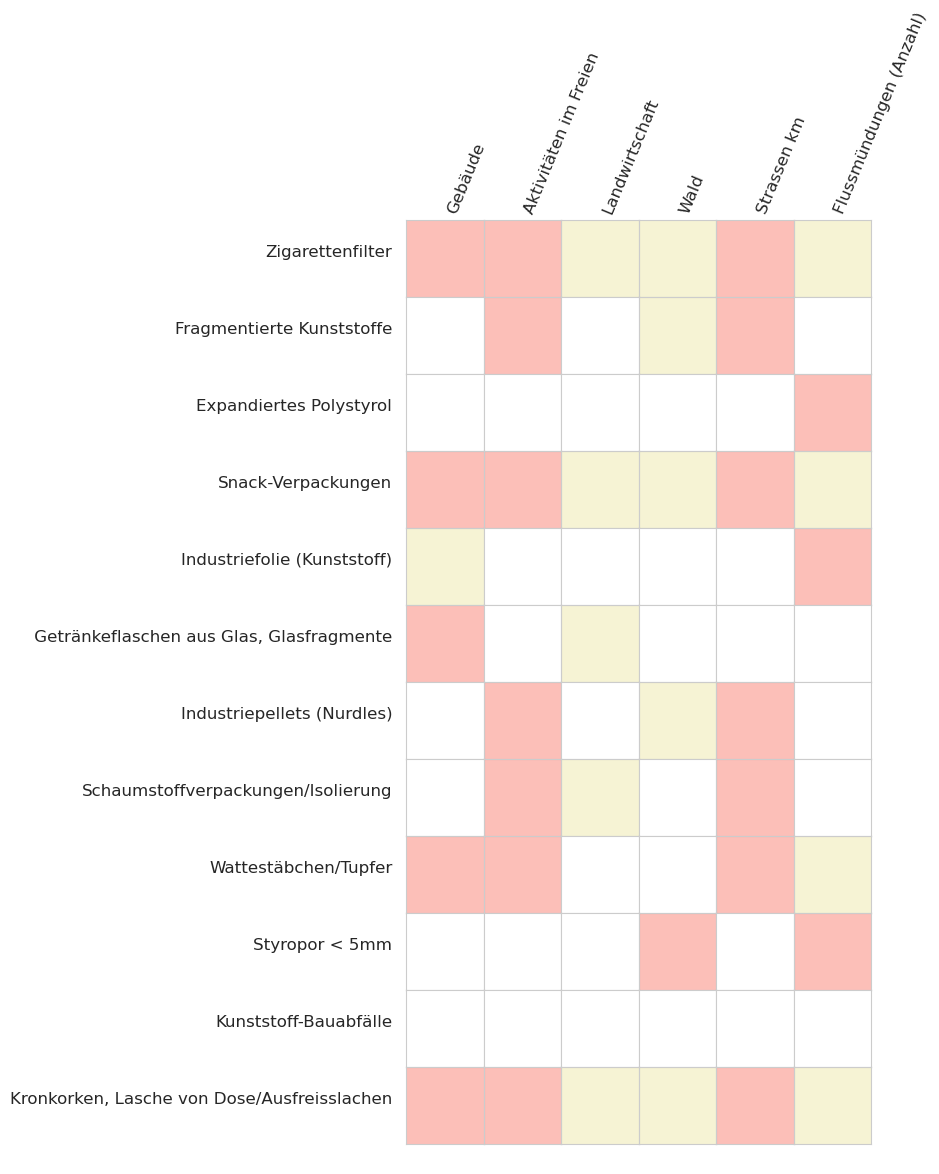

In [14]:
# add the river bassin to fd
# this needs to be updated directly
rb_map = admin_details.makeFeatureNameMap()
fd_copy = fd.copy()

fd_qq = fd[fd.water_name_slug == 'quatre-cantons'].copy()
fd_qq['water_name_slug'] = 'vierwaldstattersee'

fd = pd.concat([fd[fd.water_name_slug != 'quatre-cantons'], fd_qq])

fd["water_name"] = fd.water_name_slug.apply(lambda x: rb_map.loc[x])

corr_data = fd[(fd.code.isin(fdx.most_common.index))&(fd.water_name.isin(admin_details.lakes_of_interest))].copy()
land_use_columns = featuredata.default_land_use_columns
code_description_map = fdx.dMap

def make_plot_with_spearmans(data, ax, n, unit_label="p/100m"):
    """Gets Spearmans ranked correlation and make A/B scatter plot. Must proived a
    matplotlib axis object.
    """
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    
    if a_p < 0.05:
        if corr > 0:
            ax.patch.set_facecolor("salmon")
            ax.patch.set_alpha(0.5)
        else:
            ax.patch.set_facecolor("palegoldenrod")
            ax.patch.set_alpha(0.5)

    return ax, corr, a_p

# chart the results of test for association
fig, axs = plt.subplots(len(fdx.most_common.index),len(land_use_columns), figsize=(len(land_use_columns)*1,len(fdx.most_common.index)*1), sharey="row")

# the test is conducted on the survey results for each code
for i,code in enumerate(fdx.most_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(land_use_columns):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(f"{featuredata.luse_de[n]}", rotation=67.5, ha="left", fontsize=12)
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(f"{code_description_map[code]}", rotation=0, ha="right", labelpad=10, fontsize=12)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        ax = make_plot_with_spearmans(data, ax, n, unit_label=unit_label)


plt.subplots_adjust(wspace=0, hspace=0)
# figure caption
caption_spearmans = [
    "Ausgewertete Korrelationen der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil ",
    "im Erhebungsgebiet all. Für alle gültigen Erhebungen an Seen n=118. Legende: wenn p > 0,05 = weiss,  ",
    "wenn p < 0,05 und Rho > 0 = rot, wenn p < 0,05 und Rho < 0 = gelb.",  
]

spearmans = ''.join(caption_spearmans)


figure_name = f'{this_feature["slug"]}_survey_area_spearmans'
sample_summaries_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_summaries_file_name})

plt.savefig(**save_figure_kwargs)
glue(f'{this_feature["slug"]}_spearmans_caption', spearmans, display=False)
glue(f'{this_feature["slug"]}_survey_area_spearmans', fig, display=False)
plt.close()

```{glue:figure} all_survey_area_spearmans
---
name: 'all_survey_area_spearmans'
---
` `
```
{numref}`Abbildung %s: <all_survey_area_spearmans>` {glue:text}`all_spearmans_caption`

In [15]:
spearmans_chart = Image(sample_summaries_file_name, width=10*cm, height=15*cm, kind="proportional", hAlign= "CENTER")
caption_spearmans = Paragraph(spearmans, featuredata.caption_style)
chart_style = TableStyle([
    ('VALIGN', (0, 0), (0, -0), 'TOP'),
    ('VALIGN', (0, 1), (0,1), 'BOTTOM')
])
table_data = [[spearmans_chart, caption_spearmans]]
spearmans_table = Table(table_data, style=chart_style,colWidths=[cm*10, cm*6], rowHeights=cm*12)

new_components = [
    featuredata.large_space,
    featuredata.large_space,
    spearmans_table
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

## Verwendungszweck der gefundenen Objekte 


Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 1.8.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel  [Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe. 

In [16]:
# make pdf out put
cone_group_subtitle = Paragraph("Verwendungszweck der gefundenen Objekte", featuredata.section_title)

paragraph_one = [
    "Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, ",
    "oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. ",
    "Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. ",
    "Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert."
]

group_names_list = [
    "Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden",
    "Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion",
    "Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung",
    "Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen",
    "Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.",
    "Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien",
    "Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.",
    "Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist",
    "Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung",
    "Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung"
]

paragraph_three = [
    "Im Anhang (Kapitel 1.8.3) befindet sich die vollständige Liste der identifizierten Objekte, ",
    "einschliesslich Beschreibungen und Gruppenklassifizierung. ",
    "Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine ",
    "umfassende Liste aller Objekte in einer Gruppe."
]

paragraph_four = [
    "Der Nutzungszweck oder die Beschreibung der ",
    "identifizierten Objekte in % der Gesamtfläche der Erhebung."
]
    


# make paragraphs
code_group_para_one = ''.join(paragraph_one)
code_group_para_three = ''.join(paragraph_three)
code_group_para_four = ''.join(paragraph_four)

cgroup_pone = Paragraph(code_group_para_one, featuredata.p_style)

cgroup_pthree = Paragraph(code_group_para_three, featuredata.p_style)

a_list_groups = makeAList(group_names_list)

cgroup_pfour = Paragraph(code_group_para_four, featuredata.p_style)


new_components = [
    KeepTogether([        
        cone_group_subtitle,
        featuredata.small_space,
        cgroup_pone,
        featuredata.small_space,
        a_list_groups,
        featuredata.small_space,
        cgroup_pthree,
        featuredata.small_space,
        cgroup_pfour
    ])
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

In [17]:
components = fdx.componentCodeGroupResults()

# pivot that
pt_comp = components[["river_bassin", "groupname", '% of total' ]].pivot(columns="river_bassin", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=True)
pt_comp[top] = pt_period

# caption
code_group_percent_caption = ['Prozentuale Verteilung der identifizierten Objekte nach Verwendungszweck.']
code_group_percent_caption = ''.join(code_group_percent_caption)

# format for data frame
pt_comp.index.name = None
pt_comp.columns.name = None
aformatter = {x: '{:.0%}' for x in pt_comp.columns}
ptd = pt_comp.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, vmin=pt_comp.min().min(), vmax=pt_comp.max().max(), cmap="YlOrBr")
ptd = ptd.applymap_index(featuredata.rotateText, axis=1)

# the caption prefix is used in the case where the table needs to be split horzontally
caption_prefix =  'Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden: '

col_widths = [4.5*cm, *[1.2*cm]*(len(pt_comp.columns)-1)]
cgpercent_tables = splitTableWidth(pt_comp, gradient=True, caption_prefix=caption_prefix, caption= code_group_percent_caption,
                    this_feature=this_feature["name"], vertical_header=True, colWidths=col_widths) 


glue(f'{this_feature["slug"]}_codegroup_percent_caption', code_group_percent_caption, display=False)
glue(f'{this_feature["slug" ]}_codegroup_percent', ptd, display=False)

'Prozentuale Verteilung der identifizierten Objekte nach Verwendungszweck.'

,Aare,Linth,Rhone,Ticino,Alle Erhebungsgebiete
Abwasser,4%,2%,6%,2%,5%
Essen und Trinken,19%,22%,18%,21%,19%
Freizeit und Erholung,5%,5%,4%,2%,4%
Infrastruktur,13%,15%,22%,16%,18%
Landwirtschaft,7%,6%,5%,4%,6%
Mikroplastik (< 5mm),5%,3%,10%,10%,8%
Persönliche Gegenstände,3%,4%,2%,3%,3%
Plastikfragmente,14%,10%,15%,9%,14%
Tabakwaren,20%,24%,12%,26%,17%
Verpackungen ohne Lebensmittel/Tabak,7%,7%,4%,6%,5%


```{glue:figure} all_codegroup_percent
---
name: 'all_survey_area_codegroup_percent'
---
` `
```
{numref}`Abbildung %s: <all_survey_area_codegroup_percent>`{glue:text}`all_codegroup_percent_caption`

In [18]:
# pivot that
grouppcs_comp = components[["river_bassin", "groupname", unit_label ]].pivot(columns="river_bassin", index="groupname")

# quash the hierarchal column index
grouppcs_comp.columns = grouppcs_comp.columns.get_level_values(1)
grouppcs_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=False)
grouppcs_comp[top] = pt_period

# color gradient of restults
code_group_pcsm_gradient = featuredata.colorGradientTable(grouppcs_comp)
grouppcs_comp.index.name = None
grouppcs_comp.columns.name = None

# pdf and display output
code_group_pcsm_caption = [
    "Das Erhebungsgebiet Rhône weist die höchsten Medianwerte für ",
    "die jeweiligen Verwendungszwecke auf. Allerdings ist der prozentuale ",
    "Anteil von Objekten, die mit Tabakwaren, Essen und Trinken zu tun haben, ",
    "geringer als der von Objekten, die mit der Infrastruktur zu tun haben."
]
code_group_pcsm_caption = ''.join(code_group_pcsm_caption)

caption_prefix =  f'Verwendungszweck der gefundenen Objekte Median {unit_label} am '
col_widths = [4.5*cm, *[1.2*cm]*(len(grouppcs_comp.columns)-1)]
cgpcsm_tables = splitTableWidth(grouppcs_comp, gradient=True, caption_prefix=caption_prefix, caption=code_group_pcsm_caption,
                    this_feature=this_feature["name"], vertical_header=True, colWidths=col_widths)

if isinstance(cgpcsm_tables, (list, np.ndarray)):
    new_components = [
        featuredata.large_space,
        *cgpercent_tables,    
        featuredata.larger_space,
        *cgpcsm_tables,
        featuredata.larger_space
    ]
else:
    new_components = [
    featuredata.large_space,
    cgpercent_tables,    
    featuredata.larger_space,
    cgpcsm_tables,
    featuredata.larger_space
    ]
    
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

aformatter = {x: featuredata.replaceDecimal for x in grouppcs_comp.columns}
cgp = grouppcs_comp.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, vmin=grouppcs_comp.min().min(), vmax=grouppcs_comp.max().max(), cmap="YlOrBr")
cgp= cgp.applymap_index(featuredata.rotateText, axis=1)

glue(f'{this_feature["slug" ]}_codegroup_pcsm_caption', code_group_pcsm_caption, display=False)
glue(f'{this_feature["slug" ]}_codegroup_pcsm', cgp, display=False)

'Das Erhebungsgebiet Rhône weist die höchsten Medianwerte für die jeweiligen Verwendungszwecke auf. Allerdings ist der prozentuale Anteil von Objekten, die mit Tabakwaren, Essen und Trinken zu tun haben, geringer als der von Objekten, die mit der Infrastruktur zu tun haben.'

,Aare,Linth,Rhone,Ticino,Alle Erhebungsgebiete
Abwasser,"3,0","0,5","19,0","2,0","3,0"
Essen und Trinken,"27,0","30,5","76,0","29,0","37,0"
Freizeit und Erholung,"6,0","4,0","16,5","3,5","6,0"
Infrastruktur,"15,0","12,5","55,5","22,5","20,0"
Landwirtschaft,"6,0","3,0","14,0","6,0","7,0"
Mikroplastik (< 5mm),"1,0","0,0","11,5","0,0","1,0"
Persönliche Gegenstände,"4,0","4,0","10,0","6,5","6,0"
Plastikfragmente,"18,5","10,5","48,0","9,5","18,0"
Tabakwaren,"15,0","26,5","50,0","18,0","25,0"
Verpackungen ohne Lebensmittel/Tabak,"7,5","10,0","13,0","5,5","9,0"


```{glue:figure} all_codegroup_pcsm
---
name: 'all_survey_area_codegroup_pcsm'
---
` `
```
{numref}`Abbildung %s: <all_survey_area_codegroup_pcsm>` {glue:text}`all_codegroup_pcsm_caption`

## Fliessgewässer

'Links: Gesamtergebnisse der Erhebungen an Fliessgewässern für alle Erhebungsgebiete von März 2020 bis Mai 2021, n=55. Werte über 2000 p/100 m\xa0m sind nicht dargestellt. Rechts: Zusammenfassende Daten zu Fliessgewässern.'

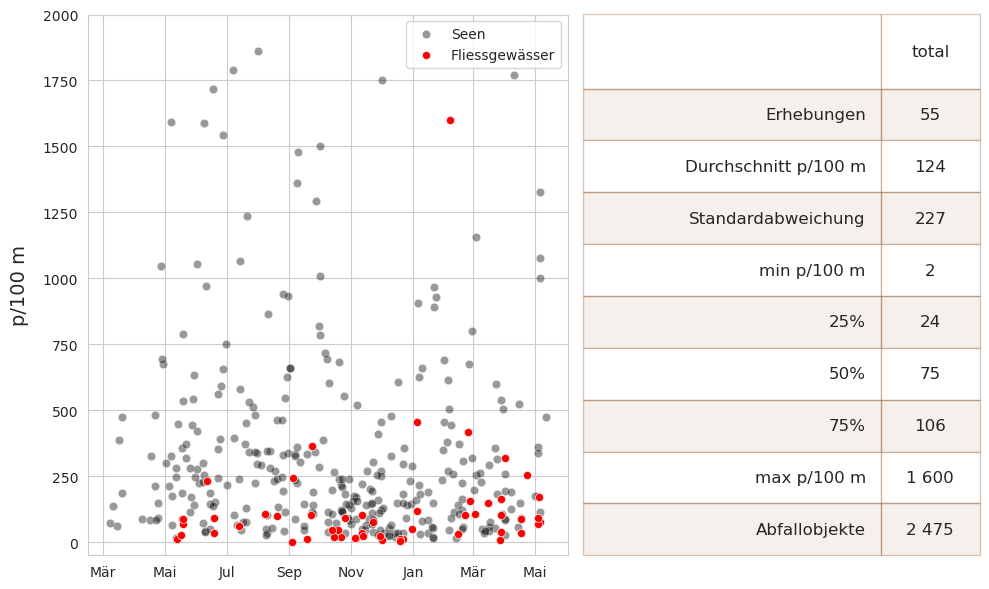

In [19]:
# summary of sample totals
rivers = fdr.sample_totals
lakes = fdx.sample_totals

csx = fdr.sample_summary.copy()
combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]

# make the charts
fig = plt.figure(figsize=(10,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=lakes, x="date", y=unit_label, color="black", alpha=0.4, label="Seen", ax=ax)
sns.scatterplot(data=rivers, x="date", y=unit_label, color="red", s=34, ec="white",label="Fliessgewässer", ax=ax)

ax.set_ylabel(unit_label, labelpad=10, fontsize=14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
# ax.margins(x=.05, y=.05)
ax.set_ylim(-50, 2000)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 6:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")
table_five.set_fontsize(12)

rivers_caption = [
    "Links: Gesamtergebnisse der Erhebungen an Fliessgewässern für alle Erhebungsgebiete von ",
    f"März 2020 bis Mai 2021, n=55. Werte über {'2000 '}{unit_label} m sind nicht dargestellt. Rechts: ",
    "Zusammenfassende Daten zu Fliessgewässern."
]

rivers_caption = ''.join(rivers_caption)


figure_name = f'{this_feature["slug"]}river_sample_totals'
river_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":river_totals_file_name})

plt.tight_layout()
plt.savefig(**save_figure_kwargs)

glue(f'{this_feature["slug" ]}_survey_area_rivers_summary_caption', rivers_caption, display=False)

glue(f'{this_feature["slug" ]}_survey_area_rivers_summary', fig, display=False)

plt.close()

```{glue:figure} all_survey_area_rivers_summary
---
name: 'all_survey_area_rivers_summary'
---
` `
```
{numref}`Abbildung %s: <all_survey_area_rivers_summary>`{glue:text}`all_survey_area_rivers_summary_caption`

__Die an Fliessgewässern am häufigsten gefundenen Objekte__

In [20]:
# the most common objects results
rmost_common_display = fdr.most_common.copy()
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})
rmost_common_display.rename(columns=cols_to_use, inplace=True)
rmost_common_display = rmost_common_display[cols_to_use.values()].copy()
rmost_common_display.set_index("Objekte", drop=True, inplace=True)

# format the data for .pdf
data = rmost_common_display.copy()
data["Anteil"] = data["Anteil"].map(lambda x: f"{int(x)}%")
data['Objekte (St.)'] = data['Objekte (St.)'].map(lambda x:featuredata.thousandsSeparator(x, language))
data['Häufigkeitsrate'] = data['Häufigkeitsrate'].map(lambda x: f"{x}%")
data[unit_label] = data[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# make caption text
mc_caption_string = [
    "Die häufigsten Objekte aus Erhebungen an Fliessgewässern. Windeln, Feuchttücher und Taschen/Tüten aus Kunststoff resp. ",
    "Fragmente davon gehören nur entlang von Fliessgewässern zu den häufigsten Objekten, nicht jedoch an Ufern von Seen. "
]
mc_caption_string = ''.join(mc_caption_string)

# make .pdf table and caption
col_widths = [4.5*cm, 2.2*cm, 2*cm, 2.8*cm, 2*cm]
r_mc_table = featuredata.aSingleStyledTable(data, colWidths=col_widths)
r_mc_table_caption = Paragraph(mc_caption_string, new_caption_style)
r_t_and_c = featuredata.tableAndCaption(r_mc_table, r_mc_table_caption, col_widths)

rmost_common_display.index.name = None
rmost_common_display.columns.name = None

# set pandas display
aformatter = {
    "Anteil":lambda x: f"{int(x)}%",
    f"{unit_label}": lambda x: featuredata.replaceDecimal(x, "de"),
    "Häufigkeitsrate": lambda x: f"{int(x)}%",   
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de")
}

mcd = rmost_common_display.style.format(aformatter).set_table_styles(table_css_styles)
glue(f'{this_feature["slug" ]}_rivers_most_common_caption', mc_caption_string, display=False)
glue(f'{this_feature["slug" ]}_rivers_most_common_tables', mcd, display=False)

'Die häufigsten Objekte aus Erhebungen an Fliessgewässern. Windeln, Feuchttücher und Taschen/Tüten aus Kunststoff resp. Fragmente davon gehören nur entlang von Fliessgewässern zu den häufigsten Objekten, nicht jedoch an Ufern von Seen. '

,Objekte (St.),Anteil,Häufigkeitsrate,p/100 m
Windeln – Feuchttücher,305,12%,23%,"0,0"
Zigarettenfilter,300,12%,63%,"4,0"
"Getränkeflaschen aus Glas, Glasfragmente",181,7%,34%,"0,0"
Industriefolie (Kunststoff),176,7%,40%,"0,0"
Snack-Verpackungen,130,5%,61%,"2,0"
Fragmentierte Kunststoffe,109,4%,54%,"2,0"
"Verpackungsfolien, nicht für Lebensmittel",87,3%,29%,"0,0"
"Kronkorken, Lasche von Dose/Ausfreisslachen",80,3%,32%,"0,0"
"Einkaufstaschen, Shoppingtaschen",60,2%,21%,"0,0"
Expandiertes Polystyrol,53,2%,20%,"0,0"


```{glue:figure} all_rivers_most_common_tables
---
name: 'all_rivers_most_common_tables'
---
` `
```
{numref}`Abbildung %s: <all_rivers_most_common_tables>` {glue:text}`all_rivers_most_common_caption`

In [21]:
rivers_section_title = Paragraph("Die an Fliessgewässern am häufigsten gefundenen Objekte", featuredata.section_title)

r_totals_caption = Paragraph(rivers_caption, new_caption_style)
r_mc_subsection = Paragraph("Die an Fliessgewässern am häufigsten gefundenen Objekte", featuredata.subsection_title)

figure_kwargs = {
    "image_file": river_totals_file_name,
    "caption": r_totals_caption,
    "desired_width": 14,
    "original_height": 15,
    "original_width": 25,
    "caption_height": 1.25,
    "style": featuredata.figure_table_style
}

r_totals_figure_and_caption = featuredata.figureAndCaptionTable(**figure_kwargs)


new_components = [
    rivers_section_title,
    featuredata.large_space,
    r_totals_figure_and_caption,
    featuredata.small_space,
    r_mc_subsection,
    featuredata.small_space,
    r_t_and_c,
]
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse 

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrags», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [22]:
annex_title = Paragraph("Anhang", featuredata.section_title)
frag_sub_title = Paragraph("Schaumstoffe und Kunststoffe nach Grösse", featuredata.subsection_title)

frag_paras = [
    "Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. ",
    "Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten ",
    "Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff - und Schaumstoffmaterialien > 0,5 ",
    "cm werden für die Analyse als Gfrags gruppiert."
]

frag_p = "".join(frag_paras)
frag = Paragraph(frag_p, featuredata.p_style)

frag_caption = [
    "Fragmentierte Kunststoffe und geschäumte Kunststoffe verschiedener ",
    f"Grössenordnungen nach Median {unit_label}, Anzahl der gefundenen Objekte ",
    "und prozentualer Anteil an der Gesamtmenge."
]
frag_captions = ''.join(frag_caption)


# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())
mask = ((before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(admin_summary["locations_of_interest"])))
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

fd_frags_foams = before_agg[mask].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: fdx.dMap.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()).round(2)

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"item":"Objekt", "quantity":"Objekte (St.)", "% of total":"Anteil"}, inplace=True)
data.set_index("Objekt", inplace=True, drop=True)
data.index.name = None

aformatter = {
    f"{unit_label}": lambda x: featuredata.replaceDecimal(x, "de"),
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Anteil":'{:.0%}',
   
}

frags_table = data.style.format(aformatter).set_table_styles(table_css_styles)

glue("all_frag_table_caption", frag_captions, display=False)
glue("all_frags_table", frags_table, display=False)

col_widths = [7*cm, *[2*cm]*(len(dims_table.columns)-1)]

frag_table = featuredata.aSingleStyledTable(data, colWidths=col_widths)
frags_table_caption = Paragraph(frag_captions, new_caption_style)
frag_table_and_caption = featuredata.tableAndCaption(frag_table, frags_table_caption, col_widths)

new_components = [
    KeepTogether([
        annex_title,
        featuredata.small_space,
        frag_sub_title,
        featuredata.smaller_space,
        frag,
        featuredata.small_space
    ]),
    frag_table_and_caption
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

'Fragmentierte Kunststoffe und geschäumte Kunststoffe verschiedener Grössenordnungen nach Median p/100 m, Anzahl der gefundenen Objekte und prozentualer Anteil an der Gesamtmenge.'

,p/100 m,Objekte (St.),Anteil
Schaumstoffverpackungen/Isolierung,"0,0",203,0%
"Objekte aus Kunststoff/Polystyrol 0,5 - 2,5 cm","0,0",495,1%
"Objekte aus Kunststoff/Polystyrol 2,5 - 50 cm","0,0",111,0%
"Objekte aus Kunststoff 0,5 - 2,5 cm","7,0",3 662,7%
"Objekte aus Kunststoff 2,5 - 50 cm","7,0",3 130,6%
Objekte aus Kunststoff > 50 cm,"0,0",2,0%
"Objekte aus expandiertem Polystyrol 0,5 - 2,5 cm","2,0",3 713,7%
"Objekte aus expandiertem Polystyrol 2,5 - 50 cm","1,0",1 843,3%
Objekte aus expandiertem Polystyrol > 50 cm,"0,0",7,0%


```{glue:figure} all_frags_table
---
name: 'all_frags_table'
---
` `
```
{numref}`Abbildung %s: <all_frags_table>` {glue:text}`all_frag_table_caption`

### Beteiligte Organisationen:

1. Precious Plastic Léman
2. Association pour la Sauvegarde du Léman
3. Geneva international School
4. Teilnehmende am Kurs zu Abfalltechnik (Solid waste engineering), Eidgenössische Technische Hochschule Lausanne
5. Summit Foundation
6. Ostschweizer Fachhochschule OST
7. Hackuarium
8. hammerdirt

In [23]:
# make the organisation list for the .pdf

some_list_items = [
    "Precious Plastic Léman",
    "Association pour la Sauvegarde du Léman",
    "Geneva international School",
    "Teilnehmende am Kurs zu Abfalltechnik (Solid waste engineering), Eidgenössische Technische Hochschule Lausanne",
    "Summit Foundation",
    "Ostschweizer Fachhochschule OST",
    "Hackuarium",
    "hammerdirt"
]

organisation_list = makeAList(some_list_items)

organisation_title = Paragraph("Organisationen:", featuredata.subsection_title)
new_components = [
    featuredata.large_space,
    organisation_title,
    featuredata.small_space,
    organisation_list
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)  

### Die Erhebungsorte

In [24]:
# display the survey locations
pd.set_option("display.max_rows", None)
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = admin_details.df_beaches.loc[admin_summary["locations_of_interest"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)
disp_beaches.set_index("standort", inplace=True, drop=True)

def aStyledTableWithTitleRow(data, header_style: Paragraph = featuredata.styled_table_header, title: str = None,
                 data_style: Paragraph = featuredata.table_style_centered, colWidths: list = None, style: list = None):
    table_data = data.reset_index()
   
    headers = [Paragraph(str(x), header_style)  for x in data.columns]
    headers = [Paragraph(" ", data_style) , *headers]
    
    if style is None:
        style = featuredata.default_table_style

    new_rows = []
    for a_row in table_data.values.tolist():
        
        if isinstance(a_row[0], str):
            row_index = Paragraph(a_row[0], featuredata.table_style_right)
            row_data = [Paragraph(str(x), data_style) for x in a_row[1:]]
            new_row = [row_index, *row_data]
            new_rows.append(new_row)
        else:
            row_data = [Paragraph(str(x), data_style) for x in a_row[1:]]
            new_rows.append(row_data)
            
    table_title_style = [
            ('FONTNAME', (0,0), (-1,-1), 'Helvetica'),
            ('FONTSIZE', (0, 0), (-1, -1), 12),
            ('ROWBACKGROUND', (0,0), (-1,-1), [colors.white]),
            ('TOPPADDING', (0, 0), (-1, -1), 3),
            ('BOTTOMPADDING', (0, 0), (-1, -1), 3)
    
        ]
        
    table_title = Table([[title]], style=table_title_style, colWidths=sum(colWidths))
    new_table = [[table_title], headers, *new_rows]
    table = Table(new_table, style=style, colWidths=colWidths, repeatRows=2)
    
    return table
    

# make this into a pdf table
location_subsection = Paragraph("Die Erhebungsorte und Inventar der Objekte", featuredata.subsection_title)
col_widths = [6*cm, 2.2*cm, 2.2*cm, 3*cm]
pdf_table = aStyledTableWithTitleRow(disp_beaches, title="Die Erhebungsorte", colWidths=col_widths)

disp_beaches

,latitude,longitude,stat
standort,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
caprino,45.987963,8.986241,Lugano
foce-del-cassarate,46.002411,8.961477,Lugano
lido,46.002004,8.962156,Lugano
lugano-centro,46.002627,8.950724,Lugano
spiaggia-parco-ciani,46.002510,8.960820,Lugano
via-brunari-spiaggia,46.202350,9.016910,Bellinzona
golene-gudo,46.170655,8.946657,Bellinzona


### Inventar der Objekte

In [25]:
pd.set_option("display.max_rows", None)
complete_inventory = fdx.code_summary.copy()
complete_inventory.sort_values(by="quantity", ascending=False, inplace=True)
complete_inventory["quantity"] = complete_inventory["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
complete_inventory["% of total"] = complete_inventory["% of total"].astype(int)
complete_inventory[unit_label] = complete_inventory[unit_label].astype(int)
complete_inventory.rename(columns=featuredata.inventory_table_de, inplace=True)

    
inventory_subsection = Paragraph("Inventar der Objekte", featuredata.subsection_title)
col_widths=[1.2*cm, 4.5*cm, 2.2*cm, 1.5*cm, 1.5*cm, 2.4*cm, 1.5*cm]
inventory_table = aStyledTableWithTitleRow(complete_inventory, title="Inventar der Objekte", colWidths=col_widths)

new_map_image =  Image('resources/maps/survey_locations_all.jpeg', width=cm*16, height=12*cm, kind="proportional", hAlign= "CENTER")
map_caption = featuredata.defaultMapCaption(language="de")

new_components = [
    KeepTogether([
        featuredata.large_space,
        location_subsection,
        featuredata.small_space,
        new_map_image,
        Paragraph(map_caption, featuredata.caption_style),
        featuredata.smaller_space,
        pdf_table,
        
    ]),
    featuredata.large_space,
    inventory_table
]
    

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

complete_inventory

,Objekte,Objekte (St.),Anteil,p/100 m,Häufigkeitsrate,Material
code,,,,,,
G27,Zigarettenfilter,8 485,15,20,87,Plastik
Gfrags,Fragmentierte Kunststoffe,7 400,13,18,86,Plastik
Gfoam,Expandiertes Polystyrol,5 563,10,5,68,Plastik
G30,Snack-Verpackungen,3 325,6,9,85,Plastik
G67,Industriefolie (Kunststoff),2 534,4,5,69,Plastik
G200,"Getränkeflaschen aus Glas, Glasfragmente",2 136,3,3,65,Glas
G112,Industriepellets (Nurdles),1 968,3,0,30,Plastik
G74,Schaumstoffverpackungen/Isolierung,1 702,3,1,53,Plastik
G95,Wattestäbchen/Tupfer,1 406,2,1,50,Plastik


In [26]:
doc = SimpleDocTemplate(pdf_link, pagesize=A4, leftMargin=2.5*cm, rightMargin=2.5*cm, topMargin=2.5*cm, bottomMargin=1*cm)

pageinfo= f"IQAASL/Ergebnisse der Erhebung/{this_feature['name']}"
source_prefix = "https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/"
source = "lakes_rivers.html"

link_to_source = f'{source_prefix}{source}'

def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setLineWidth(.001*cm)
    canvas.setFillAlpha(.8)
    canvas.line(2.5*cm, 27.6*cm,  18.5*cm, 27.6*cm) 
    canvas.setFont('Times-Roman',9)
    canvas.drawString(2.5*cm, 1*cm, link_to_source)
    canvas.drawString(18.5*cm, 1*cm,  "S.%d " % (doc.page,))
    canvas.drawString(2.5*cm, 27.7*cm, pageinfo)
    canvas.restoreState()
    
doc.build(pdfcomponents,  onFirstPage=myLaterPages, onLaterPages=myLaterPages)